
# Project: Predicting Appointment Cancellations

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling and Cleaning</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

The data set I am reviewing corresponds to 100k medical appointments which include various information about the patient including booking date, appointment date, medical conditions, age, neighborhood and whether they actually attended the appointment. At first glance, it appears that patients don't show up for approximately 30% of the appointments. I want to investigate whether this is true and what are the factors that could predict whether a patient will not attend an appointment. Factors explored will include age, gender, how long in advance the appointment was booked, number of health conditions and whether they received a reminder SMS.

In [1]:
#Import statements

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import date
from pandas.plotting import scatter_matrix
% matplotlib inline

<a id='wrangling'></a>
## Data Wrangling and Cleaning

I'll first look at a few lines in the data base and it's contents to get an idea of some issues that might need to be adjusted before analysis

In [2]:
df = pd.read_csv("no_show.csv")
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [4]:
sum(df.duplicated())

0

In [5]:
df.nunique()

PatientId          62299
AppointmentID     110527
Gender                 2
ScheduledDay      103549
AppointmentDay        27
Age                  104
Neighbourhood         81
Scholarship            2
Hipertension           2
Diabetes               2
Alcoholism             2
Handcap                5
SMS_received           2
No-show                2
dtype: int64

Here are a few observations from initially looking at some characteristics:

1. Need to change the format of the PatientId so you can see the whole number
2. The AppointmentDay and ScheduleDay type needs to be adjusted. Additionally, it looks like time was not taken into consideration for AppointmentDay so we could just utilize the date and not time. 
3. No show is confusing as a column header and I will change Yes and No to binary values to match the rest of the data presented. 
4. Handcap is spelled incorrectly, so I will correct that along with  Neighbourhood and Hipertension 
5. Handicap has 5 values when it should just have 2.
6. There are nearly twice as many AppointmentIDs as PatientID.
7. The age range seems large but not unreasonable, but I will still look into that. 


### Data Cleaning

In [6]:
# Tackling column heading name changes and format
df['PatientId'] = df['PatientId'].astype(str).str[:-2]
df.rename(columns = {"Handcap" : "Handicap"}, inplace = True)
df.rename(columns = {"PatientId" : "PatientID"}, inplace = True)
df.rename(columns = {"Neighbourhood" : "Neighborhood"}, inplace = True)
df.rename(columns = {"Hipertension" : "Hypertension"}, inplace = True)
df.head()

,PatientID,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighborhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show
0,29872499824296,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,558997776694438,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4262962299951,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,867951213174,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8841186448183,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


Most of the columns are input as "1" for yes and "0" for no, except for the "No-Show" column. A "No" for "No-show" means they did attend the appointment, which is quite confusing. I will rename the column to be "Attended" and input 1 as they were at the appointment (currently "No") and 0 as they did not attend the appointment (currently "Yes")

In [7]:
#Rename the column and use binary numbers to indicate Yes/No.
df.rename(columns = {"No-show" : "Attended"}, inplace = True)
df.Attended.replace(('Yes', 'No'), (0, 1), inplace=True)
df.head(3)

,PatientID,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighborhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,Attended
0,29872499824296,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,1
1,558997776694438,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,1
2,4262962299951,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,1


I am going to further investigate Age.

In [8]:
#Check the age range
df.Age.value_counts()

 0      3539
 1      2273
 52     1746
 49     1652
 53     1651
 56     1635
 38     1629
 59     1624
 2      1618
 50     1613
 57     1603
 36     1580
 51     1567
 19     1545
 39     1536
 37     1533
 54     1530
 34     1526
 33     1524
 30     1521
 6      1521
 3      1513
 17     1509
 32     1505
 5      1489
 44     1487
 18     1487
 58     1469
 46     1460
 45     1453
        ... 
 74      602
 76      571
 75      544
 78      541
 77      527
 80      511
 81      434
 82      392
 79      390
 84      311
 83      280
 85      275
 86      260
 87      184
 89      173
 88      126
 90      109
 92       86
 91       66
 93       53
 94       33
 95       24
 96       17
 97       11
 98        6
 115       5
 100       4
 102       2
 99        1
-1         1
Name: Age, Length: 104, dtype: int64

In [9]:
#Let's check out the weird values (-1 and over 100)
df[df.Age >= 100]

,PatientID,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighborhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,Attended
58014,976294799775439,5651757,F,2016-05-03T09:14:53Z,2016-05-03T00:00:00Z,102,CONQUISTA,0,0,0,0,0,0,1
63912,31963211613981,5700278,F,2016-05-16T09:17:44Z,2016-05-19T00:00:00Z,115,ANDORINHAS,0,0,0,0,1,0,0
63915,31963211613981,5700279,F,2016-05-16T09:17:44Z,2016-05-19T00:00:00Z,115,ANDORINHAS,0,0,0,0,1,0,0
68127,31963211613981,5562812,F,2016-04-08T14:29:17Z,2016-05-16T00:00:00Z,115,ANDORINHAS,0,0,0,0,1,0,0
76284,31963211613981,5744037,F,2016-05-30T09:44:51Z,2016-05-30T00:00:00Z,115,ANDORINHAS,0,0,0,0,1,0,1
79270,9739429797896,5747809,M,2016-05-30T16:21:56Z,2016-05-31T00:00:00Z,100,TABUAZEIRO,0,0,0,0,1,0,1
79272,9739429797896,5747808,M,2016-05-30T16:21:56Z,2016-05-31T00:00:00Z,100,TABUAZEIRO,0,0,0,0,1,0,1
90372,234283596548,5751563,F,2016-05-31T10:19:49Z,2016-06-02T00:00:00Z,102,MARIA ORTIZ,0,0,0,0,0,0,1
92084,55783129426615,5670914,F,2016-05-06T14:55:36Z,2016-06-03T00:00:00Z,100,ANTÔNIO HONÓRIO,0,0,0,0,0,1,1
97666,748234579244724,5717451,F,2016-05-19T07:57:56Z,2016-06-03T00:00:00Z,115,SÃO JOSÉ,0,1,0,0,0,1,1


It looks like for 3 of the 115 year old values, it's the same patient. There are only 5 entries for 115 year old and 1 for -1 year old. I am going to delete these entries.

In [10]:
#Delete the 115 and -1
df = df[df.Age > 0]
df = df[df.Age < 103]

Why does Handcap have 5 unique values and how many entries are affected?

In [11]:
df.Handicap.value_counts()

0    104746
1      2037
2       183
3        13
4         3
Name: Handicap, dtype: int64

According to the Kaggle website, Handicap should also be a true/false value. Reading in the questions, Pete wrote that "0" means no handicap, "1" means handicap and "2" and "3" are errors. Since there are less than 0.1% that have values of 2,3, or 4, I will delete all rows that are not 0 and 1. I will change the column header from "Handcap" to "Handicap"

In [12]:
#keep on the rows that are less than 2 (0 or 1) and verify
df = df[df.Handicap < 2]

For the ScheduleDay and AppointmentDay, one includes the time and the other just the date, so I want to strip the time and just utilize the date. I also want to convert it from an object to datetime format so I can subtract it. It might be useful to know the difference in the number of days between booking the appointment and when the appointment occurred, so I will create a new column to document this.

In [13]:
#I want to delete the time by stripping it. There might be a way to do
#this using .date()

split_columns = ['ScheduledDay','AppointmentDay']
for c in split_columns:
    df[c] = df[c].apply(lambda x: x.split("T")[0])
    
#convert to datetime type
df['ScheduledDay'] = pd.to_datetime(df.ScheduledDay)
df['AppointmentDay'] = pd.to_datetime(df.AppointmentDay)

#Create a new column that has the difference in days between the
#ScheduledDay and the AppointmentDay
DaysDifference = df['AppointmentDay'] - df['ScheduledDay']
df['DaysDifference'] = DaysDifference
df.head(3)

,PatientID,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighborhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,Attended,DaysDifference
0,29872499824296,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,1,0 days
1,558997776694438,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,1,0 days
2,4262962299951,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,1,0 days


In [14]:
#DaysDifference is datetime format which is not compatable for comparison, so I changed the type to int.

df['DaysDifference'] = df['DaysDifference'].apply(lambda x: x.days)

In [15]:
df.DaysDifference.value_counts()

 0      37076
 2       6623
 4       5201
 1       5019
 7       4783
 6       3941
 5       3185
 14      2806
 3       2630
 8       2244
 21      1787
 13      1621
 28      1616
 9       1563
 15      1438
 10      1357
 20      1148
 22      1135
 16      1108
 12      1081
 17      1075
 29      1038
 19      1011
 18       998
 27       979
 11       955
 35       909
 23       788
 34       770
 26       711
        ...  
 109        5
 112        5
 96         4
 98         4
-1          4
 102        4
 119        4
 105        4
 103        4
 111        3
 122        3
 92         3
 115        2
 93         2
 110        2
 107        2
 97         2
 94         2
 123        1
 101        1
 126        1
 125        1
 139        1
 151        1
 132        1
 117        1
 146        1
 82         1
-6          1
 127        1
Name: DaysDifference, Length: 131, dtype: int64

There are some negative values I need to look at

In [16]:
len(df[df.DaysDifference <0])

5

In [17]:
df[df.DaysDifference <0]

,PatientID,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighborhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,Attended,DaysDifference
27033,7839272661752,5679978,M,2016-05-10,2016-05-09,38,RESISTÊNCIA,0,0,0,0,1,0,0,-1
55226,7896293967868,5715660,F,2016-05-18,2016-05-17,19,SANTO ANTÔNIO,0,0,0,0,1,0,0,-1
64175,24252258389979,5664962,F,2016-05-05,2016-05-04,22,CONSOLAÇÃO,0,0,0,0,0,0,0,-1
71533,998231581612122,5686628,F,2016-05-11,2016-05-05,81,SANTO ANTÔNIO,0,0,0,0,0,0,0,-6
72362,3787481966821,5655637,M,2016-05-04,2016-05-03,7,TABUAZEIRO,0,0,0,0,0,0,0,-1


There are only 5 instances so I am going to delete them.

In [18]:
df = df[df.DaysDifference >= 0]

In [19]:
df[df.DaysDifference <0]

,PatientID,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighborhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,Attended,DaysDifference


I want to investigate the patients that made multiple appointments. Let's find the patient that has the most appointments

In [20]:
df.PatientID.value_counts()

822145925426128    88
99637671331        84
26886125921145     70
33534783483176     65
258424392677       62
75797461494159     62
6264198675331      62
871374938638855    62
66844879846766     57
872278549442       55
89239687393655     54
8435223536         51
853439686798559    50
65433599726992     46
14479974122994     46
9452745294842      42
81894521843749     42
188232341789524    40
2271579924275      38
9496196639835      38
13364929297498     37
1484143378533      35
88834999836575     34
986162815579582    34
712458866975343    33
416755661551767    30
6128878448536      30
81213966782532     29
8634164126317      24
1198157171975      23
                   ..
95695594656747      1
1984246918437       1
2869766492677       1
46311567771491      1
91361268957915      1
644628859465886     1
97716341836846      1
7781234442345       1
429639741847284     1
83252539242883      1
4494934283393       1
895766336673        1
7927784398392       1
4254211333893       1
5282285199

In [21]:
#Let's look closer at the Patient that has the most appointments
df[df.PatientID == "822145925426128"]

,PatientID,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighborhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,Attended,DaysDifference
3006,822145925426128,5638995,M,2016-04-29,2016-04-29,38,REDENÇÃO,0,0,0,0,0,0,1,0
3060,822145925426128,5642878,M,2016-04-29,2016-04-29,38,REDENÇÃO,0,0,0,0,0,0,1,0
3093,822145925426128,5640809,M,2016-04-29,2016-04-29,38,REDENÇÃO,0,0,0,0,0,0,1,0
6984,822145925426128,5705135,M,2016-05-16,2016-05-16,38,REDENÇÃO,0,0,0,0,0,0,1,0
6985,822145925426128,5668887,M,2016-05-06,2016-05-06,38,REDENÇÃO,0,0,0,0,0,0,1,0
7009,822145925426128,5735078,M,2016-05-24,2016-05-24,38,REDENÇÃO,0,0,0,0,0,0,1,0
7032,822145925426128,5710752,M,2016-05-17,2016-05-17,38,REDENÇÃO,0,0,0,0,0,0,1,0
7129,822145925426128,5736811,M,2016-05-25,2016-05-25,38,REDENÇÃO,0,0,0,0,0,0,1,0
7133,822145925426128,5711913,M,2016-05-18,2016-05-18,38,REDENÇÃO,0,0,0,0,0,0,1,0
7198,822145925426128,5682166,M,2016-05-10,2016-05-13,38,REDENÇÃO,0,0,0,0,0,0,1,3


They have many appointments that have the same AppointmentDay and ScheduleDay. In fact, the rows appear to be the same except that the AppointmentID is different. How many entries does this affect?

In [22]:
mult_app = df.PatientID.value_counts()
mult_app.value_counts()

1     36787
2     13277
3      5255
4      2273
5      1089
6       538
7       303
8       201
9       104
10       85
11       63
12       36
13       35
14       22
15       15
17       10
16       10
20        8
18        8
19        6
62        4
21        3
23        2
30        2
46        2
38        2
42        2
34        2
57        1
35        1
65        1
29        1
24        1
33        1
88        1
51        1
37        1
55        1
70        1
54        1
22        1
84        1
50        1
40        1
Name: PatientID, dtype: int64

I'm not sure we need the AppointmentID and if we delete it, we can see if there are duplicates.

In [23]:
df.drop('AppointmentID', axis =1, inplace = True)

#find the number of duplicated entries
sum(df.duplicated())

4122

There are 4122 entries where the same Person ID has multiple entires with the same date. It could be the case that they scheduled multiple appointments (may be a facility with different doctors) or it could be an error. It's most likely probable that if they show up for one appointment, they will also go to the other appointments that day, so it does not necessarily add valueable information. Since this is about 3.7% of the total entries, I will delete duplicates.

In [24]:
df.drop_duplicates(inplace = True)

I'm curious to know the time period of this set of data

In [25]:
print(df.ScheduledDay.max())
print(df.ScheduledDay.min())
print(df.AppointmentDay.max())
print(df.AppointmentDay.min())

2016-06-08 00:00:00
2015-11-10 00:00:00
2016-06-08 00:00:00
2016-04-29 00:00:00


The appointments are just between a span of a little more than a month. The scheduled day is about 7 months prior to the first appointment and ends on the first appointment day. There could have been some appointments scheduled after the first appointment day during the appointment duration, but they neglect this.

<a id='eda'></a>
## Exploratory Data Analysis

### What are the factors that could predict whether a patient will not attend an appointment?

Questions to answer:

1. What is the percentage of unattended appointments?
2. Does gender play a role in cancellations?
3. Does the number of days booked prior to an appointment affect it?
4. Does the number of health conditions? 
5. Does age play a role?
6. Does receiving an SMS reminder aid in ensuring patients attend appointments?


### What is the percentage of unattended appointments

In [26]:
#First generally, now many attended the appointment
df.Attended.mean()

0.7952774314214464

20% of the appointments result in a no-show.

### Does gender play a role in cancellations?

In [27]:
#how many females and males are in the data set and how many attended
df.Gender.value_counts(),\
df.groupby('Gender')['Attended'].value_counts()

(F    67796
 M    34860
 Name: Gender, dtype: int64, Gender  Attended
 F       1           53877
         0           13919
 M       1           27763
         0            7097
 Name: Attended, dtype: int64)

In [28]:
#percentage of female appointments 
print(len(df.query("Gender == 'F'"))/len(df))

0.6604192643391521


In [29]:
#Percentage of females that attended appointments and percentage of males that attended appointments
print(len(df.query("Gender == 'F' & Attended==1"))/len(df.query("Gender == 'F'")))
print(len(df.query("Gender == 'M' & Attended==1"))/len(df.query("Gender == 'M'")))

0.7946929022361201
0.7964142283419392


Females accounted for 2/3 of the appointments. There was very little difference between female and males attending appointments (79.5% and 79.6% respectively). Gender does not seem to play a role in whether or not they attended.

### Does the number of days between booking and appointment date affect whether the patient attends the appointment

In [30]:
df.DaysDifference.describe()

count    102656.000000
mean         10.395895
std          15.381245
min           0.000000
25%           0.000000
50%           4.000000
75%          15.000000
max         179.000000
Name: DaysDifference, dtype: float64

There's a pretty significant difference between the mean at 10 and the median at 4 which indicates many outliers.

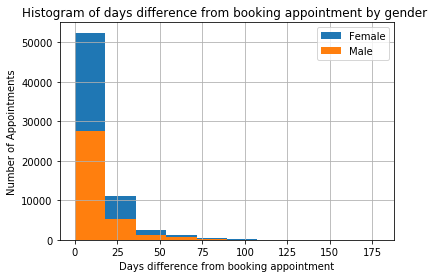

In [52]:
df.groupby('Gender')['DaysDifference'].hist();
plt.xlabel('Days difference from booking appointment');
plt.ylabel('Number of Appointments');
plt.title('Histogram of days difference from booking appointment by gender ');
plt.legend(['Female','Male'])

Representation that the majority of appointmentments are scheduled just a few days prior. Let's look at the percentages of Attendance versus DayDifference at the first 15 days.

In [36]:
lists = []
for days_difference in range(15):
    AttendperDay = len(df.query("Attended == 1 & DaysDifference == {}".format(days_difference)))
    AppointperDayDiff = len(df.query("DaysDifference == {}".format(days_difference)))
    lists.append((days_difference, AttendperDay/AppointperDayDiff))

In [37]:
lists

[(0, 0.9546639332259481),
 (1, 0.7866585316249746),
 (2, 0.7615408132069703),
 (3, 0.7650928792569659),
 (4, 0.7680652680652681),
 (5, 0.7389787503964478),
 (6, 0.7529532614278377),
 (7, 0.7340017064846417),
 (8, 0.7111517367458866),
 (9, 0.7257959714100065),
 (10, 0.6837735849056604),
 (11, 0.6810344827586207),
 (12, 0.6836638338054769),
 (13, 0.6823308270676691),
 (14, 0.690631808278867)]

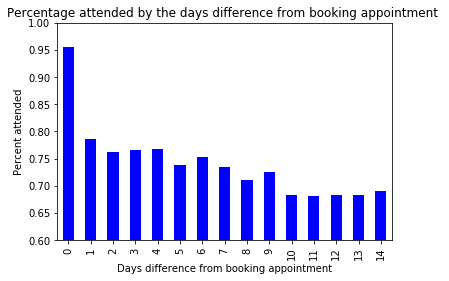

In [65]:
listsDD = pd.DataFrame(lists)
listsDD[1].plot(kind ='bar', color='b');
plt.ylim(.6, 1);
plt.xlabel('Days difference from booking appointment');
plt.ylabel('Percent attended');
plt.title('Percentage attended by the days difference from booking appointment ');

There's a 15% decrease from booking the same day versus the next day. After 10 days it drops below 70% attendance.

In [39]:
#lets look at the whole set of data and not just the first few days.
lists_exp = []
for days_start, days_end in [(0,0), (1,1), (2,2), (3,3), (4,4), (5,5), (6,6), (7,7), (8,8), (9,9), (10,10), (11,20), (21,50), (51,180)]:  
  if not len(df.query("DaysDifference >= {} & DaysDifference <= {}".format(days_start,days_end))) == 0:
    lists_exp.append(((days_start,days_end), len(df.query("Attended==1 & DaysDifference >= {} & DaysDifference <= {}".format(days_start,days_end))) /len(df.query("DaysDifference >= {} & DaysDifference <= {}".format(days_start,days_end)))))

In [40]:
x,y = zip(*lists_exp)

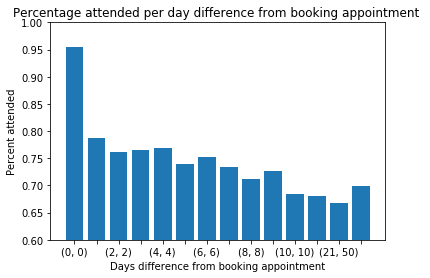

In [41]:
fig = plt.figure();
ax = fig.add_subplot(111);
ax.bar(range(0,len(lists_exp)),y);
ax.set_xticks(range(0,len(lists_exp)));
for label in ax.set_xticklabels(x)[1::2]:
    label.set_visible(False)
plt.ylim(.6, 1);
plt.xlabel('Days difference from booking appointment');
plt.ylabel('Percent attended');
plt.title('Percentage attended per day difference from booking appointment ');

If you book the appointment the same day, there is a 95% chance you will attend. After 10 days the precentage is less than 70%

### Does the number of health conditions play a factor?

In [42]:
#create a new column for number of health factors (Hypertension, Diabetes, Alcoholism, Handicap)
HealthFactors = df['Hypertension'] + df['Diabetes'] + df['Alcoholism'] + df['Handicap']
df['HealthFactors'] = HealthFactors
df['HealthFactors'].value_counts()

0    77477
1    17293
2     7312
3      563
4       11
Name: HealthFactors, dtype: int64

In [43]:
tmp = df.groupby('Attended')['HealthFactors'].value_counts().unstack(0)
tmp

Attended,0,1
HealthFactors,,
0,16472,61005
1,3135,14158
2,1321,5991
3,85,478
4,3,8


In [44]:
tmp["Percentage_Attended"] = tmp[1]/ (tmp[0] + tmp[1])
tmp

Attended,0,1,Percentage_Attended
HealthFactors,,,
0,16472,61005,0.787395
1,3135,14158,0.818713
2,1321,5991,0.819338
3,85,478,0.849023
4,3,8,0.727273


In [45]:
pd.set_option('float_format', '{:.3f}'.format)

In [46]:
tmp

Attended,0,1,Percentage_Attended
HealthFactors,,,
0,16472,61005,0.787
1,3135,14158,0.819
2,1321,5991,0.819
3,85,478,0.849
4,3,8,0.727


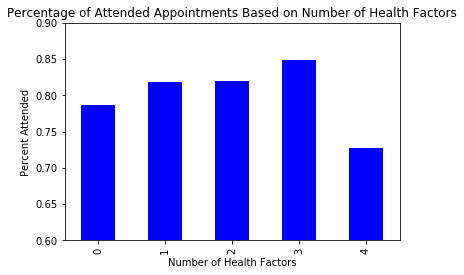

In [55]:
ax = tmp["Percentage_Attended"].plot(kind = 'bar', color='b')
ax.set_xlabel("Number of Health Factors")
ax.set_ylabel("Percent Attended")
plt.title('Percentage of Attended Appointments Based on Number of Health Factors')
plt.ylim(.6, .9);

You are more likely to attend an appointment if you have multiple health conditions, with the exception of having more than 3.

### Does age play a role?

In [49]:
Alists = []
for ages in range(100):
    AttendperAge = len(df.query("Attended == 1 & Age == {}".format(ages)))
    AppointperAge = len(df.query("Age == {}".format(ages)))
    if not AppointperAge == 0:
        Alists.append((ages, AttendperAge/AppointperAge))

In [50]:
AlistsAge = pd.DataFrame(Alists)

In [51]:
AlistsAge[1].mean()

0.8057291868152081

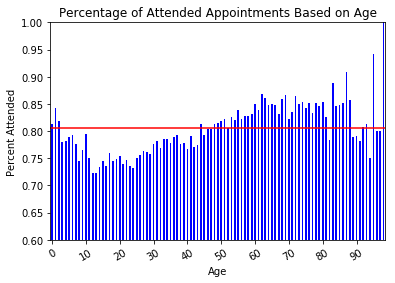

In [69]:
AlistsAge[1].plot(kind ='bar', color='b')
plt.xlabel("Age")
plt.ylabel("Percent Attended")
plt.title('Percentage of Attended Appointments Based on Age')
plt.ylim(.6, 1);
tick_prop = np.arange(0,90+10,10)
plt.xticks(tick_prop, tick_prop, rotation = 30);
plt.axhline(y=AlistsAge[1].mean(), color='r', linestyle='-')

In [524]:
AlistsAge

,0,1
0,1,0.814
1,2,0.842
2,3,0.818
3,4,0.781
4,5,0.782
5,6,0.789
6,7,0.792
7,8,0.776
8,9,0.744
9,10,0.766


There's a drop in attendance from from early teen years and then increases after that.

In [525]:
Agrouplists = []
for age_start, age_end in [(0,10), (10,20), (20,30), (30,40), (40,50), (50,60), (60,70), (70,80), (80,90), (90,100)]:
    AttendperAge = len(df.query("Attended == 1 & Age >= {} & Age <= {}".format(age_start, age_end)))
    AppointperAge = len(df.query("Age >= {} & Age <= {}".format(age_start, age_end)))
    if not len(df.query("Age >= {} & Age <= {}".format(age_start,age_end))) == 0:
        Agrouplists.append(((age_start, age_end), AttendperAge/AppointperAge))      

In [526]:
xg,yg = zip(*Agrouplists)

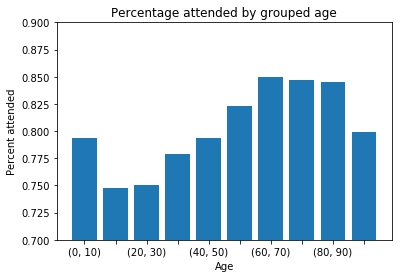

In [527]:
fig = plt.figure();
ax = fig.add_subplot(111);
ax.bar(range(0,len(Agrouplists)),yg);
ax.set_xticks(range(0,len(Agrouplists)));
for label in ax.set_xticklabels(xg)[1::2]:
    label.set_visible(False)
plt.ylim(.7, .9);
plt.xlabel('Age');
plt.ylabel('Percent attended');
plt.title('Percentage attended by grouped age');

Someone between the ages of 10 and 40 were less likely to attend the appointment.

<a id='eda'></a>
### Does receiving an SMS reminder aid in ensuring patients attend appointments?

In [528]:
tmp = df.groupby('Attended')['SMS_received'].value_counts().unstack(0)
tmp["Percentage"] = tmp[1]/ (tmp[0] + tmp[1])
tmp

Attended,0,1,Percentage
SMS_received,,,
0,11460,56667,0.832
1,9556,24973,0.723


Strange. A person was more likely to attend if they did not receive an SMS. Lets look at who received an SMS

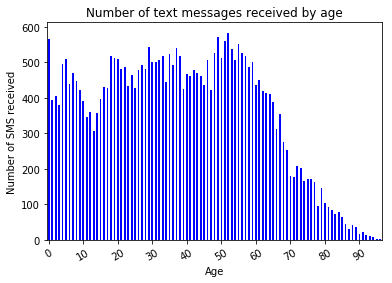

In [73]:
df.query('SMS_received==1')['Age'].value_counts().sort_index().plot(kind = 'bar', color = 'b');
tick_prop = np.arange(0,90+10,10)
plt.xlabel('Age');
plt.ylabel('Number of SMS received');
plt.title('Number of text messages received by age');
plt.xticks(tick_prop, tick_prop, rotation = 30);

There seems to be a significant drop off after about 60, and there is a dip in teenage years.

In [74]:
SMSlists = []
for ages in range(100):
    AttendperAgeSMS = len(df.query("Attended == 1 & SMS_received ==1 & Age == {}".format(ages)))
    AppointperAgeSMS = len(df.query("SMS_received==1 & Age == {}".format(ages)))
    if not AppointperAgeSMS == 0:
        SMSlists.append((ages, AttendperAgeSMS/AppointperAgeSMS))

In [75]:
SMSlistsAge = pd.DataFrame(SMSlists)

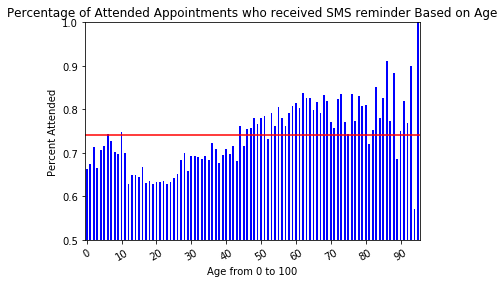

In [80]:
SMSlistsAge[1].plot(kind ='bar', color = 'b')
plt.xlabel("Age from 0 to 100")
plt.ylabel("Percent Attended")
plt.title('Percentage of Attended Appointments who received SMS reminder Based on Age')
plt.ylim(.5, 1);
tick_prop = np.arange(0,90+10,10)
plt.xticks(tick_prop, tick_prop, rotation = 30);
plt.axhline(y=SMSlistsAge[1].mean(), color='r', linestyle='-');

In [81]:
lists_exp = []
for days_start, days_end in [(0,10), (10,20), (20,30), (30,40), (40,50), (50,60), (60,70), (70,80), (80,90), (90,100)]:  
    AttendperAgeSMS = len(df.query("Attended == 1 & SMS_received ==1 & Age >= {} & Age <= {}".format(days_start,days_end)))
    AppointperAgeSMS = len(df.query("SMS_received==1 & Age >= {} & Age <= {}".format(days_start,days_end)))
    if not len(df.query("Age >= {} & Age <= {}".format(days_start,days_end))) == 0:
        lists_exp.append(((days_start,days_end), AttendperAgeSMS/AppointperAgeSMS))           

In [82]:
x,y = zip(*lists_exp)

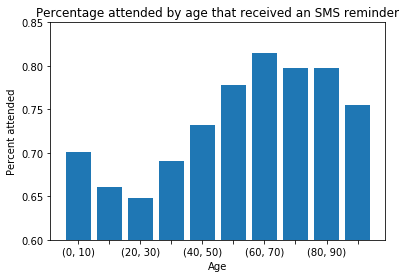

In [83]:
fig = plt.figure();
ax = fig.add_subplot(111);
ax.bar(range(0,len(lists_exp)),y);
ax.set_xticks(range(0,len(lists_exp)));
for label in ax.set_xticklabels(x)[1::2]:
    label.set_visible(False)
plt.ylim(.6, .85);
plt.xlabel('Age');
plt.ylabel('Percent attended');
plt.title('Percentage attended by age that received an SMS reminder');

A reminder SMS message did improve attendance for those 40 and over.

<a id='conclusions'></a>
## Conclusions

Since I did not perform any statistical analysis, the following findings are general observations and would need to be further vetted.

1. 80% of the appointments were attended, meaning 20% were no-shows.
2. Though 2/3 of the appointments were booked by women, gender does not seem to play a role in no-shows.
3. The number of days prior to the appointment does affect the likelyhood whether one attends. If the appointment is booked day of, one was 95% likely to attend. This number drops to just below 80% at one day prior and then drops below 70% at day 10.
4. One with more chronic health conditions was more likely to attend the appointment, than one with no chronic medical conditions.
5. Those between the ages of 10 and 40 were less likely to attend the appointment.
6. Looking at the entire dataset, receiving an SMS reminder message actually reduced the likelyhood one would attend. With further investigation, it did seem to improve attendance with those over the age of 40.

### Limitations

This study was exploratory and is meant to provide insights to warrant further analysis. Therefore there are many limitations.

The relationships between features were not sufficiently investigated. Regressions were not performed on the characteristics, so we do not know exactly how correlated the data is and what the confidence interval is.

It would also be useful to have a data set that was for a longer period of time. The appointments ranged from April 29 2016 to June 8 2016, a period of 40 days.

The analysis of this data set did tell us that it would be of benefit to further study these trends. Next steps would be to use a bigger dataset spanning a longer period of time and utilizations of regressions and predictive modeling.


